# Óbitos por COVID-19 Brasil

Author: P. H. P. Cintra

Website: [https://sites.google.com/view/pedrocintra](https://sites.google.com/view/pedrocintra)

Twitter/Instagram: [@pedrocintra52](https://www.instagram.com/pedrocintra52)

$$\hspace{1cm}$$

Bem vindo/Bem vinda/Bem vinde, neste jupyter notebook encontra-se o código utilizado por mim para estimar o número mais próximo do real de óbitos por COVID-19 no Brasil. Para isso, utilizo os dados do portal [Bigdata-covid19](https://bigdata-covid19.icict.fiocruz.br/) da Fiocruz, os dados do [OurWorldInData](https://ourworldindata.org/coronavirus), os boletins epideiológicos do final de [2016](https://antigo.saude.gov.br/images/pdf/2017/janeiro/05/Informe-Epidemiologico-Influenza-2016-SE-52.pdf) e [2017](https://antigo.saude.gov.br/images/pdf/2017/dezembro/27/Informe-Epidemiologico-Influenza-2017-SE-51.pdf) e os boletins epidemiológicos deste ano de [2021](https://gitlab.procc.fiocruz.br/mave/repo/-/tree/master/Boletins%20do%20InfoGripe/boletins_anteriores). Utilizando a comparação entre óbitos por síndrome respiratória aguda grave (SRAG) nos anos de 2016 a 2019, e o ano de 2020, eu estimo o real numero de óbitos por COVID-19 no final de 2020/início de 2021. Com esta estiamtiva, eu estimo qual a % de subnotificação de mortes no Brasil e finalmente, utilizo os dados atuais de mortes registradas para estimar qual o numero real de mortos por COVID-19 no Brasil. Alguns pontos devem ser discutidos antes disso:

1. Ao comparar os anos anteriores de 2016 a 2019 com 2020, verei o quanto o ano de 2020 está em excesso comparado à média dos anteriores. Entretanto, pode-se argumentar que o ano de 2020 pode ter tido mais casos de doenças respiratórias, alem da COVID, o que naturalmente aumentaria o registro de óbitos por SRAG naturalmente. O problema deste argumento é que, devido ao isolamento social, a tendência é que os casos de SRAG causados por outros agentes infecciosos (como o Influenza, que causa a gripe) diminua. Porém, para evitar este possível viés, irei comparar o excesso de 2020 com a média de 2016-2019 e a margem de 95% CI dada pela distribuição [t-student](https://en.wikipedia.org/wiki/Student%27s_t-distribution) (que tenderia a convergir para um desvio padrão típico 2$\sigma$ de uma gaussiana, caso a quantidade de anos incluídos anteriormente a 2020 fosse muito grande. Como essa quantidade não é muito grande, a margem de 95% CI da distribuição t-student é maior que o típico desvio padrão 2$\sigma$ de uma gaussiana), para eliminar melhor a possibilidade de que este excesso esteja contaminando a estiamtiva com óbitos de SRAG que não foram de COVID.
2. Após encontrar a % de subnotificação de mortes, eu suponho que este valor não se altere até os dias atuais,veremos que a % de subnotificação tendeu a aumentar no ano de 2020, mas se estabilizou nas últimas 20 semanas epidemiológicas, indicando que esta suposição é válida.
3. A análise que farei consta com dados baixados no dia 06/03/2021, sinta-se livre para acessar os links mencionados anteriormente e baixar os dados mais recentes do [OurWorldInData](https://ourworldindata.org/coronavirus) e do [Bigdata-covid19](https://bigdata-covid19.icict.fiocruz.br/) para fazer uma estimativa mais recente.
4. Não encontrei o boletim epidemiológico correspondente à 52ª semana de 2017, apenas até a 51. Assim, interpolei o registro da 51ª semana na 52ª para completar o calendário epidemiológico. Isso não deve alterar os resultados, poís o final do ano não é temporada de vírus respiratórios no Brasil e assim, os últimos registros não possuem uma flutuação muito grande.
5. Nos boletins epidemiológicos de 2016 e 2017, não há tabelas com os dados de óbitos registrados em cada semana, apenas um gráfico de barras. Para obter estes valores, tive que extrair manualmente os pontos do gráfico pelo site [https://apps.automeris.io/wpd/](https://apps.automeris.io/wpd/). Isso trouxe alguns erros na extração dos valores. Entretanto, os erros não foram grandes, em 2016 minha extração manual provocou um erro de 1.7% a mais de mortes registradas do que o boletim oficial e em 2017 um excesso de 1.6%. Portanto, estes erros são pequenos demais para alterar os resultados de forma relevante, além de estarem acima do registrado, de forma que sua única contribuição nas margens de erro acaba sendo em aumentar a margem de 95% CI. Ajudando ainda mais a previnir a inclusão de óbitos por outras causas na estimativa de óbitos por COVID.
6. Semanas epidemiologicas 1 e 2 de 2021 foram interpoladas linearmente

In [1]:
# Importando bibliotecas
import pandas as pd # Para importar arquivos e dados
import numpy as np # Funções e conceitos matemáticos
import matplotlib.pyplot as plt # Gráficos
import scipy.stats as st #statistical functions

In [33]:
# Importando os dados do repositório no GitHub
srag_since_2020 = pd.read_csv('https://raw.githubusercontent.com/PedroHPCintra/COVID_Brasil/master/SRAG_desde2020.csv')
srag = pd.read_csv('https://raw.githubusercontent.com/PedroHPCintra/COVID_Brasil/master/SRAG.csv')
fiocruz = pd.read_csv('https://raw.githubusercontent.com/PedroHPCintra/COVID_Brasil/master/fiocruz_sivep_gripe.csv')
owid = pd.read_csv('https://raw.githubusercontent.com/PedroHPCintra/COVID_Brasil/master/owid-covid-data.csv')

In [3]:
srag_since_2020.tail()

,Semana epidemiológica desde 2020,SRAG: obitos cumulativo desde 2020,COVID: obitos desde 2020
57,58,319646,230034
58,59,328861,238532
59,60,337444,245997
60,61,349627,254221
61,62,364516,264325


In [4]:
fiocruz.head()

,Semana epidemiológicaobito 2018,SRAG: óbitosobito 2018,Semana epidemiológicaobito 2019,SRAG: óbitosobito 2019,Semana epidemiológicaobito 2020,SRAG: óbitosobito 2020,Semana epidemiológicaobitocovid 2020,SRAG: óbitosobitocovid 2020,Semana epidemiológicaobitocovid 2021,SRAG: óbitosobitocovid 2021,Semana epidemiológicaÓbitos MS,SRAG: óbitosÓbitos MS
0,1.0,49.0,1.0,44.0,1,82,1,0,1.0,6009.0,1,6906
1,2.0,91.0,2.0,85.0,2,167,2,0,2.0,11589.0,2,13571
2,3.0,127.0,3.0,130.0,3,253,3,0,3.0,16155.0,3,20720
3,4.0,160.0,4.0,172.0,4,336,4,0,4.0,19775.0,4,28220
4,5.0,197.0,5.0,209.0,5,442,5,0,5.0,23282.0,5,35287


In [5]:
srag.head()

,Semana epidemiológica,SRAG: obitos 2016,SRAG: obitos cumulativo 2016,SRAG: obitos 2017,SRAG: obitos cumulativo 2017,SRAG: obitos cumulativo 2018,SRAG: obitos cumulativo 2019,SRAG: obitos cumulativo 2020,COVID: obitos 2020,SRAG: obitos cumulativo 2021,COVID: obitos 2021,Semana epidemiologica inicio,SRAG: obitos cumulativo inicio,COVID: obitos inicio
0,1,27.0,27.0,40.0,40.0,49.0,44.0,82,0,303001.0,202631.0,1,82,0
1,2,27.0,54.0,37.0,77.0,91.0,85.0,167,0,303708.0,209296.0,2,167,0
2,3,34.0,88.0,29.0,106.0,127.0,130.0,253,0,304415.0,216445.0,3,253,0
3,4,27.0,115.0,36.0,142.0,160.0,172.0,336,0,310907.0,223945.0,4,336,0
4,5,39.0,154.0,38.0,180.0,197.0,209.0,442,0,319646.0,230034.0,5,442,0


In [6]:
# Media e desvio padrão de 2016 a 2019
mean_early_years = np.mean([np.array(fiocruz['SRAG: óbitosobito 2018']),
                            np.array(fiocruz['SRAG: óbitosobito 2019']),
                           np.array(srag['SRAG: obitos cumulativo 2017']),
                           np.array(srag['SRAG: obitos cumulativo 2016'])], axis = 0)
std_early_years = np.std([np.array(fiocruz['SRAG: óbitosobito 2018']),
                          np.array(fiocruz['SRAG: óbitosobito 2019']),
                         np.array(srag['SRAG: obitos cumulativo 2017']),
                         np.array(srag['SRAG: obitos cumulativo 2016'])], axis=0)

In [7]:
# Dataframe com as médias e desvios padrões
stats = pd.DataFrame({'Semana epidemiológica': [i+1 for i in range(53)],
                     'SRAG: obito media': mean_early_years,
                     'SRAG: obito std': std_early_years})

In [8]:
# Calculo dos intervalos de confiança
low95, up95 = st.t.interval(alpha=0.95, df=3,
            loc=stats['SRAG: obito media'],
            scale=stats['SRAG: obito std'])

/home/pedroc/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1976: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


In [9]:
stats['95% CI lower'] = low95
stats['95% CI upper'] = up95

In [10]:
stats.tail()

,Semana epidemiológica,SRAG: obito media,SRAG: obito std,95% CI lower,95% CI upper
48,49,5283.00,1419.666686,764.987000,9801.013000
49,50,5304.50,1420.995162,782.259197,9826.740803
50,51,5327.75,1423.053473,798.958732,9856.541268
51,52,5344.50,1425.287076,808.600410,9880.399590
52,53,NaN,NaN,NaN,NaN


In [11]:
next_year_mean = (np.array(stats['SRAG: obito media'])[:-1]+np.array(stats['SRAG: obito media'])[-2])
mean_since_2020 = np.concatenate((np.array(stats['SRAG: obito media'])[:-1], np.array(stats['SRAG: obito media'])[-2:-1], next_year_mean, next_year_mean[-1:]))

next_year_std = (np.array(stats['SRAG: obito std'])[:-1]+np.array(stats['SRAG: obito std'])[-2])
std_since_2020 = np.concatenate((np.array(stats['SRAG: obito std'])[:-1], np.array(stats['SRAG: obito std'])[-2:-1], next_year_std, next_year_std[-1:]))

next_year_low = (np.array(stats['95% CI lower'])[:-1]+np.array(stats['95% CI lower'])[-2])
low_since_2020 = np.concatenate((np.array(stats['95% CI lower'])[:-1], np.array(stats['95% CI lower'])[-2:-1], next_year_low, next_year_low[-1:]))

next_year_up = (np.array(stats['95% CI upper'])[:-1]+np.array(stats['95% CI upper'])[-2])
up_since_2020 = np.concatenate((np.array(stats['95% CI upper'])[:-1], np.array(stats['95% CI upper'])[-2:-1], next_year_up, next_year_up[-1:]))

In [12]:
stats_since_2020 = pd.DataFrame({'Semana epidemiológica': [i+1 for i in range(106)],
                                'SRAG: obito media': mean_since_2020,
                                'SRAG: obito std': std_since_2020,
                                '95% CI lower': low_since_2020,
                                '95% CI upper': up_since_2020})

/home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/pedroc/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1.0, 'Óbitos cumulativos por SRAG no período de dois anos comuns')

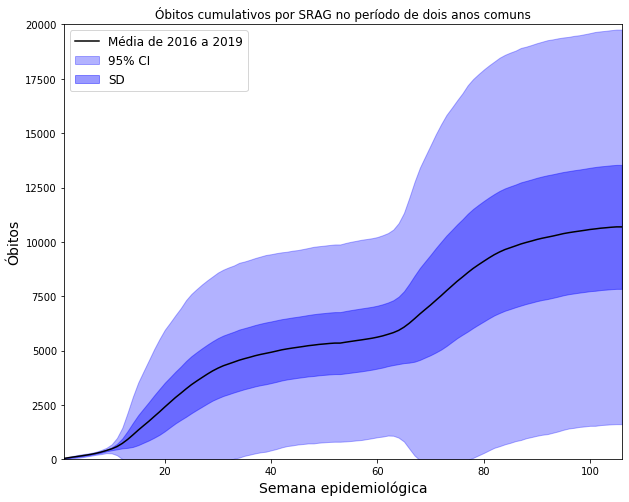

In [13]:
# Comportamento médio de 2019 e 2018
plt.figure(figsize=(10,8))
plt.plot(np.array(stats_since_2020['Semana epidemiológica']), stats_since_2020['SRAG: obito media'],
        color = 'black', label = 'Média de 2016 a 2019')
plt.fill_between(np.array(stats_since_2020['Semana epidemiológica']), stats_since_2020['95% CI lower'], 
                stats_since_2020['95% CI upper'], alpha = 0.3, color = 'blue', label = r'95% CI')
plt.fill_between(np.array(stats_since_2020['Semana epidemiológica']), stats_since_2020['SRAG: obito media'] - stats_since_2020['SRAG: obito std'], 
               stats_since_2020['SRAG: obito media'] + stats_since_2020['SRAG: obito std'], alpha = 0.4, color = 'blue',
                 label = r'SD')
plt.legend(loc='upper left', fontsize = 12)
plt.xlabel('Semana epidemiológica', fontsize = 14)
plt.ylabel('Óbitos', fontsize = 14)
plt.xlim(1, 106)
plt.ylim(0, 20000)
plt.title('Óbitos cumulativos por SRAG no período de dois anos comuns')
#plt.savefig('/home/pedroc/Documentos/pedro/Coronavirus/Graficos/SRAG_2018_2019.png',
#            bbox_inches = 'tight', dpi = 300)

In [24]:
recent_week = 62

Text(0.5, 1.0, '*SRAG = Síndrome Respiratória Aguda Grave')

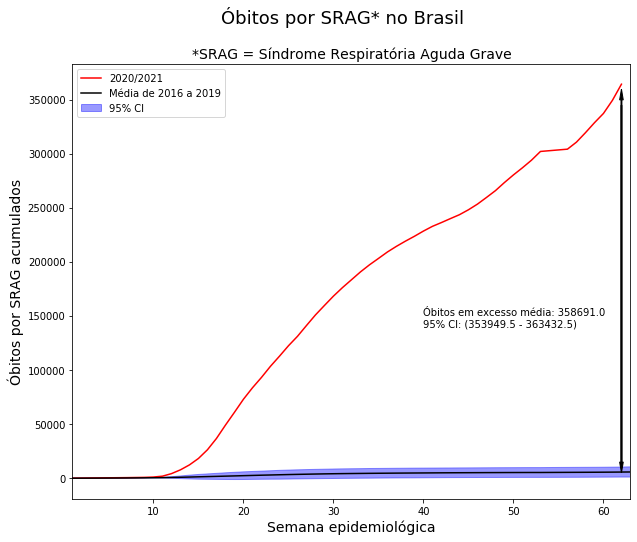

In [20]:
# 2020
plt.figure(figsize=(10,8))
plt.plot(np.array(srag_since_2020['Semana epidemiológica desde 2020']),
         np.array(srag_since_2020['SRAG: obitos cumulativo desde 2020']),
        color = 'red', label = '2020/2021')
plt.plot(np.array(stats_since_2020['Semana epidemiológica']), stats_since_2020['SRAG: obito media'],
        color = 'black', label = 'Período normal')
plt.fill_between(np.array(stats_since_2020['Semana epidemiológica']), stats_since_2020['95% CI lower'], 
                stats_since_2020['95% CI upper'], alpha = 0.4, color = 'blue', label = r'95% CI')
plt.legend(loc='upper left')
plt.xlim(1, 63)
plt.arrow(recent_week, 10000, 0, 340000, width = 0.1, head_width = 0.4, head_length = 10000, color = 'black')
plt.arrow(recent_week, 345000, 0, -330000, width = 0.1, head_width = 0.4, head_length = 10000, color = 'black')
plt.text(40, 150000, f"Óbitos em excesso média: {(np.array(srag_since_2020['SRAG: obitos cumulativo desde 2020'])[-1] - np.array(stats_since_2020['SRAG: obito media'])[62]):.1f}")
plt.text(40, 140000,
         f"95% CI: ({(np.array(srag_since_2020['SRAG: obitos cumulativo desde 2020'])[-1] - np.array(stats_since_2020['95% CI upper'])[62]):.1f} - {(np.array(srag_since_2020['SRAG: obitos cumulativo desde 2020'])[-1] - np.array(stats_since_2020['95% CI lower'])[62]):.1f})")
plt.xlabel('Semana epidemiológica', fontsize = 14)
plt.ylabel('Óbitos por SRAG acumulados', fontsize = 14)
plt.suptitle('Óbitos por SRAG* no Brasil', fontsize = 18)
plt.title('*SRAG = Síndrome Respiratória Aguda Grave', fontsize = 14)
#plt.savefig('/home/pedroc/Documentos/pedro/Coronavirus/Graficos/SRAG_2020.png',
#            bbox_inches = 'tight', dpi = 300)

(0, 63)

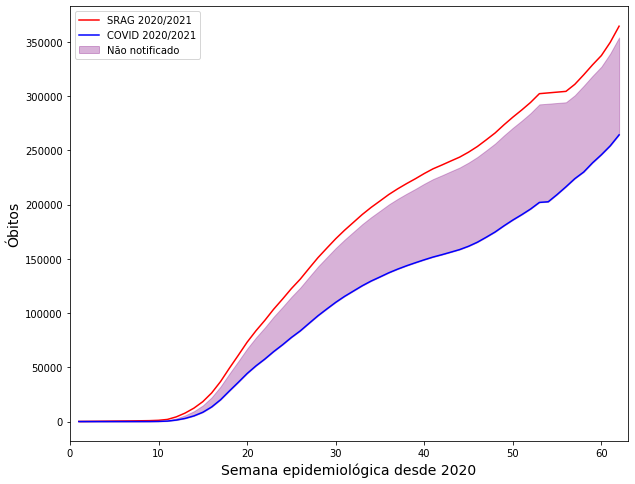

In [23]:
# Diferença entre óbito registrado como COVID e óbito de SRAG total com a subnotificação estimada
plt.figure(figsize=(10,8))
plt.plot(np.array(srag_since_2020['Semana epidemiológica desde 2020']),
         np.array(srag_since_2020['SRAG: obitos cumulativo desde 2020']),
        color = 'red', label = 'SRAG 2020/2021')
plt.plot(np.array(srag_since_2020['Semana epidemiológica desde 2020']),
         np.array(srag_since_2020['COVID: obitos desde 2020']),
        color = 'blue', label = 'COVID 2020/2021')
plt.fill_between(srag_since_2020['Semana epidemiológica desde 2020'],
                 np.array(srag_since_2020['COVID: obitos desde 2020']),
                np.array(srag_since_2020['SRAG: obitos cumulativo desde 2020'])-np.array(stats_since_2020['95% CI upper'][:recent_week]),
                 color = 'purple', alpha = 0.3, label = 'Não notificado')
plt.legend(loc = 'upper left')
plt.xlabel('Semana epidemiológica desde 2020', fontsize = 14)
plt.ylabel('Óbitos', fontsize = 14)
plt.xlim(0, 63)
#plt.savefig('/home/pedroc/Documentos/pedro/Coronavirus/Graficos/SRAG_covid_2020.png',
#            bbox_inches = 'tight', dpi = 300)

In [25]:
# Calculo da subnotificação durante o período de 2020
subnotification = np.array(srag_since_2020['COVID: obitos desde 2020'])/(np.array(srag_since_2020['SRAG: obitos cumulativo desde 2020']) - stats_since_2020['SRAG: obito media'][:recent_week])
subnotification_low = np.array(srag_since_2020['COVID: obitos desde 2020'])/(np.array(srag_since_2020['SRAG: obitos cumulativo desde 2020']) - np.array(stats_since_2020['95% CI lower'])[:recent_week])
subnotification_up = np.array(srag_since_2020['COVID: obitos desde 2020'])/(np.array(srag_since_2020['SRAG: obitos cumulativo desde 2020']) - np.array(stats_since_2020['95% CI upper'])[:recent_week])

Text(32, 0.55, 'Capacidade mais recente: 0.737 das mortes\n                95% CI: (0.727 - 0.746)')

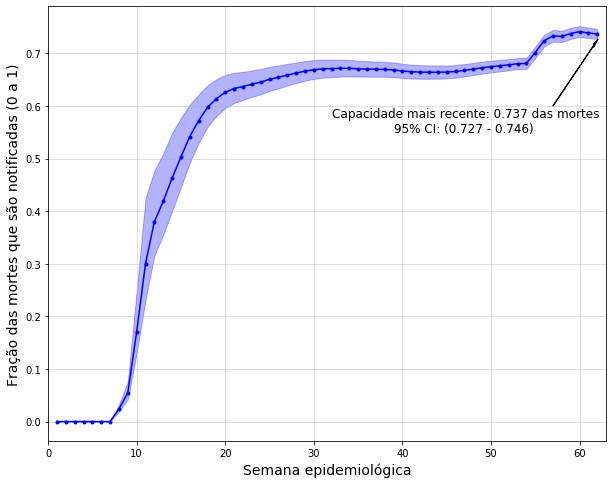

In [30]:
# Andamento da subnotificação durante 2020
plt.figure(figsize=(10,8))
plt.grid(True, alpha = 0.5)
plt.plot(np.array(srag_since_2020['Semana epidemiológica desde 2020']), subnotification,
         linewidth = 1.5, color = 'blue')
plt.plot(np.array(srag_since_2020['Semana epidemiológica desde 2020']), subnotification, 'b.')
plt.fill_between(srag_since_2020['Semana epidemiológica desde 2020'], subnotification_low,
                subnotification_up, color = 'blue', alpha = 0.3)

plt.xlabel('Semana epidemiológica', fontsize = 14)
plt.ylabel('Fração das mortes que são notificadas (0 a 1)', fontsize = 14)
plt.xlim(0, recent_week+1)
#plt.ylim(0, 0.7)
plt.arrow(57, 0.6, 4.6, 0.115, head_width = 0.007, head_length = 0.5, color = 'black')
plt.text(32, 0.55, f'Capacidade mais recente: {subnotification[recent_week-1]:.3f} das mortes'
         '\n'
         f'                95% CI: ({subnotification_low[recent_week-1]:.3f} - {subnotification_up[recent_week-1]:.3f})',
         fontsize = 12)
#plt.savefig('/home/pedroc/Documentos/pedro/Coronavirus/Graficos/Subnotification_covid.png',
#            bbox_inches = 'tight', dpi = 300)

In [31]:
# Valor mais recente de subnotificação
subnotification_recent = subnotification[recent_week-1]
subnotification_recent_low = subnotification_low[recent_week-1]
subnotification_recent_up = subnotification_up[recent_week-1]

In [32]:
print(f'Notificação de mortes equivalente a {100*subnotification_recent:.2f} (95% CI: {100*subnotification_recent_low:.2f} - {100*subnotification_recent_up:.2f}%) do real')

Notificação de mortes equivalente a 73.68 (95% CI: 72.73 - 74.64%) do real


In [34]:
# Valor mais recente de mortes no Brasil
Brasil = owid[owid['location'] == 'Brazil']
last_register = np.array(Brasil['total_deaths'])[-1]

In [35]:
print(f'Ultimo registro: {last_register}')

Ultimo registro: 270656.0


In [36]:
# Estimativa do valor mais realístico de mortes no Brasil
actual_deaths = (2-subnotification_recent)*last_register
actual_deaths_low = (2-subnotification_recent_low)*last_register
actual_deaths_up = (2-subnotification_recent_up)*last_register

In [37]:
print(f'Numero mais realístico de mortos por COVID-19 no Brasil até o momento: {int(actual_deaths)} (95% CI: {int(actual_deaths_low)} - {int(actual_deaths_up)})')

Numero mais realístico de mortos por COVID-19 no Brasil até o momento: 341903 (95% CI: 344458 - 339282)
